# ETL

## Extract

Zuerst wollen wir die Daten herunterladen. Hier ist zu beachten, dass dieser Datensatz Linzensiert ist, weshabl er hier auch nicht direkt mit aufgenommen wurde. Der Datensatz kann einerseits [von IEEE](https://ieee-dataport.org/documents/realwaste#files) heruntergeladen werden, dafür wird jedoch ein IEEE Account benötigt. Alternativ kann er auch mit der folgenden Zelle von GitHub heruntergeladen werden. 

In [5]:
import os
import sys
import shutil

# Function to check if running in Google Colab
def in_colab():
    return 'google.colab' in sys.modules

# Define the base path for the dataset
if in_colab():
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Assuming the dataset is in "drive/My Drive/RealWaste" in Google Drive
    dataset_path = '/content/drive/My Drive/RealWaste'
else:
    # Path in your local container
    dataset_path = '/realwaste/data'

# Ensure the dataset directory exists (specifically for local container, as Colab will have it in Drive)
if not in_colab():
    os.makedirs(dataset_path, exist_ok=True)  # Create the directory if it doesn't exist

# Clone the repository only if the dataset does not already exist
if not os.listdir(dataset_path):  # Checks if the dataset directory is empty
    !git clone https://github.com/sam-single/realwaste.git {dataset_path}
    # Remove unnecessary files and directories
    readme_path = os.path.join(dataset_path, 'README.md')
    if os.path.exists(readme_path):
        os.remove(readme_path)
    realwaste_dir = os.path.join(dataset_path, 'RealWaste')
    if os.path.isdir(realwaste_dir):
        shutil.move(realwaste_dir+'/*', dataset_path)  # Move files out of RealWaste to dataset_path
        shutil.rmtree(realwaste_dir)  # Remove the now-empty RealWaste directory
    git_dir = os.path.join(dataset_path, '.git')
    if os.path.isdir(git_dir):
        shutil.rmtree(git_dir)  # Remove the .git directory

print("Dataset Path: ", dataset_path)


Dataset Path:  /realwaste/data


In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import inception_v3
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import math

# Define transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to match Inception V3 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assuming dataset_path is already defined from the previous steps
dataset = ImageFolder(root=f'{dataset_path}', transform=transform)

# Total number of images in the dataset
total_images = len(dataset) 

# Calculate the sizes for training and validation sets
train_size = int(math.ceil(0.8 * total_images))
valid_size = total_images - train_size

# Split the dataset
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# Applying the same transformations for both datasets
# Note: You might want to apply different transformations for training and validation in practice.

# Define DataLoader for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)



In [14]:
# Load Inception V3 pre-trained model
model = inception_v3(pretrained=True)

# Adapt the classifier to the number of classes in the RealWaste dataset
# Assuming 9 classes from your dataset description
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 9)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [15]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [16]:
# Simple training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Get only the main output from the model
        outputs, _ = model(inputs)  # This unpacks the main and auxiliary outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 86.00 MiB. GPU 0 has a total capacity of 7.77 GiB of which 99.38 MiB is free. Process 70290 has 5.73 GiB memory in use. Of the allocated memory 5.37 GiB is allocated by PyTorch, and 163.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Append actual and predicted labels for later evaluation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')  # 'weighted' accounts for label imbalance
    precision = precision_score(y_true, y_pred, average='weighted')
    
    return accuracy, recall, precision

accuracy, recall, precision = evaluate_model(model, valid_loader, device)
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')


Accuracy: 88.53%
Recall: 88.53%
Precision: 88.72%


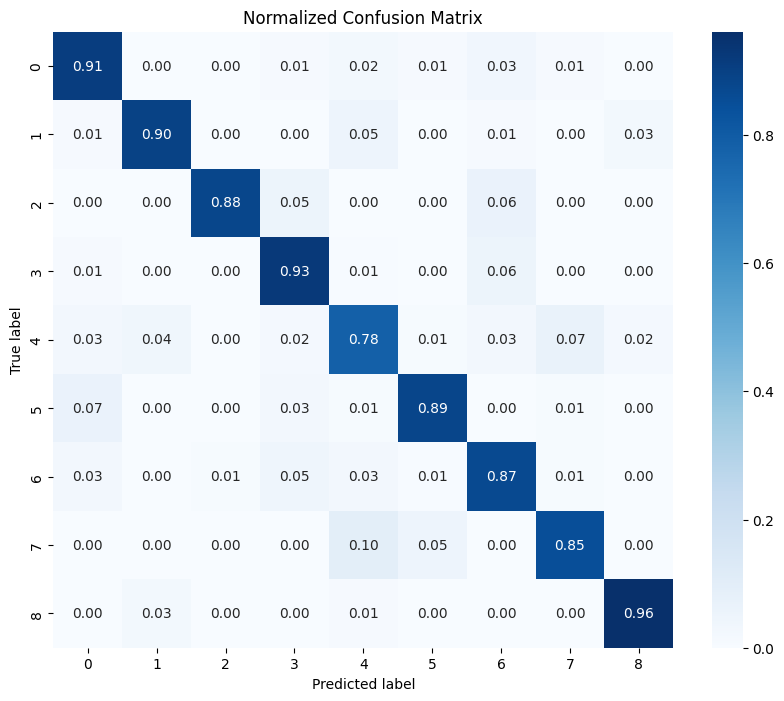

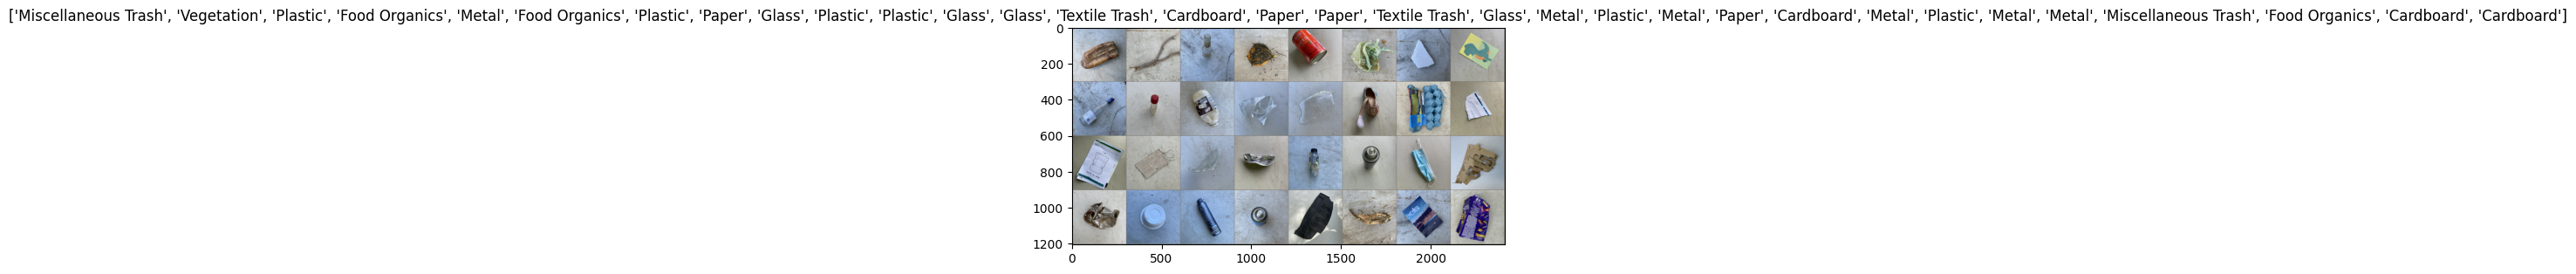

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For a nicer confusion matrix visualization
import torchvision

y_true = []
y_pred = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of validation data
inputs, classes = next(iter(valid_loader))
outputs = model(inputs.to(device))
_, preds = torch.max(outputs, 1)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = valid_dataset.dataset.classes  # Assuming using ImageFolder or similar for dataset loading
imshow(out, title=[class_names[x] for x in preds.cpu().numpy()])


In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Function to display images in a grid with annotations for true and predicted classes
def show_images_grid(images, true_labels, pred_labels, class_names):
    # Set number of images per row
    num_images = len(images)
    num_rows = int(np.sqrt(num_images))
    num_cols = (num_images // num_rows) + (0 if num_images % num_rows == 0 else 1)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*2.5, num_rows*2.5))
    axes = axes.flatten()

    for i, (image, true_label, pred_label) in enumerate(zip(images, true_labels, pred_labels)):
        ax = axes[i]
        img = image.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", color=("green" if true_label == pred_label else "red"), fontsize=8)
        ax.axis('off')

    # If the number of images is not a perfect square, we might have some empty plots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Get a batch of validation data
inputs, classes = next(iter(valid_loader))
outputs = model(inputs.to(device))
_, preds = torch.max(outputs, 1)

# Class names
class_names = train_dataset.dataset.classes  # Make sure to have this from your dataset

# Call the function
show_images_grid(inputs, classes, preds, class_names)
